# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-4 below, which you need to complete as instructed.

**Refer to the material in units 7-8 for conceptual background.**

In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from nltk.corpus import stopwords
nltk.download('stopwords')  
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [4]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [5]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [6]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [7]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    #print("lines per character", character_line_count)
    return character_docs

In [8]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [9]:
train_character_docs['JACK']

"Oi. Where have you been? Huh? What were the texts about? _EOL_ Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar. _EOL_ It's on the house. Are you alright? _EOL_ I left the night wallet at home. I'm gonna be about ten minutes. _EOL_ Are you alright? You've been a bit off since you got here. _EOL_ So that's why you were late? You had a little set up planned? _EOL_ Well, how about I pour you a glass of this and take you through what might've happened. So, I would've given you this. Then what? _EOL_ And then? _EOL_ Fair dos. I think we talk, we'd have a laugh and then that moment would come. _EOL_ The moment where we're too close for it to be friends. The one where I can smell the perfume on your skin and I wonder who is brave enough to ... _EOL_ Tea. _EOL_ Nice hotels not far. Go to one of them. Or do you only like to do that when you're cheating on Tanya? _EOL_ Not much, no. You've got a perfectly good house of your own. Which you'd be

# Q1. Improve pre-processing (10 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.

- Lowercase (done)
- Remove puncuation (done)
- Remove stopwords (done)
- End of line should not be a token (done)
- lemmatize the document (done)


In [10]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    
    # Tokenizing sentence
    stpwords = []
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(character_text)  
    tokens = [token.lower() for token in tokens]

    # Stop word removal
    stpwords = stopwords.words('english') + ['_eol_']
    tokens = [word for word in tokens if not word in stpwords]
    
    # Lemmatization doesnt seem to be very good as WordNetLemmatizer needs POS tags to work better
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    print (tokens)
    return tokens

In [11]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

['lesley', 'really', 'glad', 'must', 'ian', 'partner', 'ashley', 'lovely', 'little', 'place', 'seen', 'flesh', 'ashley', 'lesley', 'compare', 'way', 'described', 'keep', 'forgetting', 'lesley', 'changed', 'name', 'would', 'therapist', 'bloke', 'make', 'might', 'say', 'indicates', 'attempt', 'run', 'away', 'something', 'let', 'go', 'amongst', 'thing', 'sister', 'called', 'love', 'hate', 'relationship', 'love', 'hate', 'right', 'jane', 'love', 'much', 'break', 'heart', 'bottle', 'best', 'champagne', 'please', 'start', 'counting', 'penny', 'jane', 'paying', 'ash', 'know', 'ian', 'exactly', 'imagined', 'say', 'ash', 'kind', 'bloke', 'jane', 'would', 'end', 'marrying', 'mean', 'david', 'always', 'going', 'tough', 'act', 'follow', 'word', 'think', 'found', 'yeah', 'well', 'ash', 'hampstead', 'heath', 'really', 'allowed', 'say', 'well', 'authority', 'take', 'dim', 'view', 'probation', 'officer', 'dating', 'client', 'well', 'certainly', 'act', 'like', 'probation', 'officer', 'quiet', 'jane', '

['maybe', 'know', 'like', 'thinking', 'going', 'matter', 'two', 'decide', 'lucy', 'bobby', 'like', 'going', 'cafe', 'way', 'bad', 'feeling', 'go', 'away', 'denise', 'strong', 'get', 'others', 'worry', 'denise', 'girl', 'ian', 'stuff', 'right', 'like', 'said', 'something', 'missing', 'spent', 'lot', 'time', 'last', 'couple', 'week', 'scared', 'angry', 'know', 'matter', 'none', 'really', 'matter', 'sitting', 'round', 'table', 'like', 'enough', 'already', 'something', 'pat', 'said', 'important', 'let', 'eat', 'care', 'ian', 'care', 'puff', 'pastry', 'got', 'consistency', 'brick', 'care', 'steven', 'steven', 'yes', 'steven', 'like', 'inside', 'head', 'sorry', 'must', 'go', 'want', 'ride', 'u', 'share', 'room', 'peter', 'bobby', 'steven', 'move', 'fair', 'make', 'lucy', 'share', 'age', 'saying', 'give', 'try', 'cause', 'end', 'matter', 'done', 'family', 'course', 'ian', 'going', 'pick', 'bobby', 'school', 'want', 'anything', 'supermarket', 'fine', 'yeah', 'well', 'got', 'thank', 'ian', 'yea

['another', 'drink', 'lightweight', 'let', 'see', 'got', 'shall', 'oh', 'look', '21', 'year', 'old', 'whisky', 'let', 'shall', 'max', 'prefers', 'younger', 'seany', 'sean', 'sean', 'point', 'going', 'bed', 'early', 'new', 'year', 'eve', 'yep', 'well', 'wanted', 'u', 'together', 'mother', 'perogative', 'go', 'get', 'jim', 'jam', 'watch', 'big', 'ben', 'together', 'tub', 'ice', 'cream', 'bye', 'want', 'hear', 'crap', 'get', 'house', 'max', 'scream', 'think', 'said', 'get', 'want', 'coming', 'boxed', 'set', 'count', 'one', 'choice', 'young', 'lady', 'yes', 'speaking', 'believe', 'okay', 'right', 'getting', 'dressed', 'someone', 'broke', 'salon', 'last', 'night', 'thanks', 'dot', 'bradley', 'great', 'one', 'thing', 'max', 'get', 'see', 'okay', 'mean', 'go', 'try', 'talk', 'want', 'godsend', 'got', 'go', 'salon', 'pick', 'moment', 'time', 'okay', 'someone', 'broke', 'yeah', 'funny', 'thing', 'sign', 'forced', 'entry', 'could', 'walk', 'lock', 'last', 'night', 'forgot', 'go', 'thinking', 'hi

In [12]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
     
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    
    return counts  

In [13]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)


In [14]:
training_feature_matrix

<16x3664 sparse matrix of type '<class 'numpy.float64'>'
	with 10814 stored elements in Compressed Sparse Row format>

In [15]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062
['cheap', 'aftershave', 'think', 'running', 'chip', 'shop', 'nut', 'ian', 'beale', 'think', 'lucky', 'mine', 'married', 'christian', 'jane', 'brother', 'come', 'sister', 'kept', 'one', 'quiet', 'like', 'grant', 'gay', 'bar', 'know', 'barmaid', 'fancy', 'jane', 'wait', 'clay', 'drawing', 'impurity', 'male', 'grooming', 'around', 'century', 'ian', 'egyptian', 'men', 'wore', 'make', 'roman', 'dyed', 'hair', 'bath', 'house', 'want', 'help', 'wish', 'continue', 'walking', 'earth', 'dirty', 'unscrubbed', 'hairy', 'strictly', 'monochromatic', 'colour', 'crew',

In [16]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [17]:
val_feature_matrix

<16x3664 sparse matrix of type '<class 'numpy.float64'>'
	with 1890 stored elements in Compressed Sparse Row format>

In [18]:
training_feature_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [20]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [21]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [22]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 2.1875
mean cosine similarity 0.549714911630024
11 correct out of 16 / accuracy: 0.6875


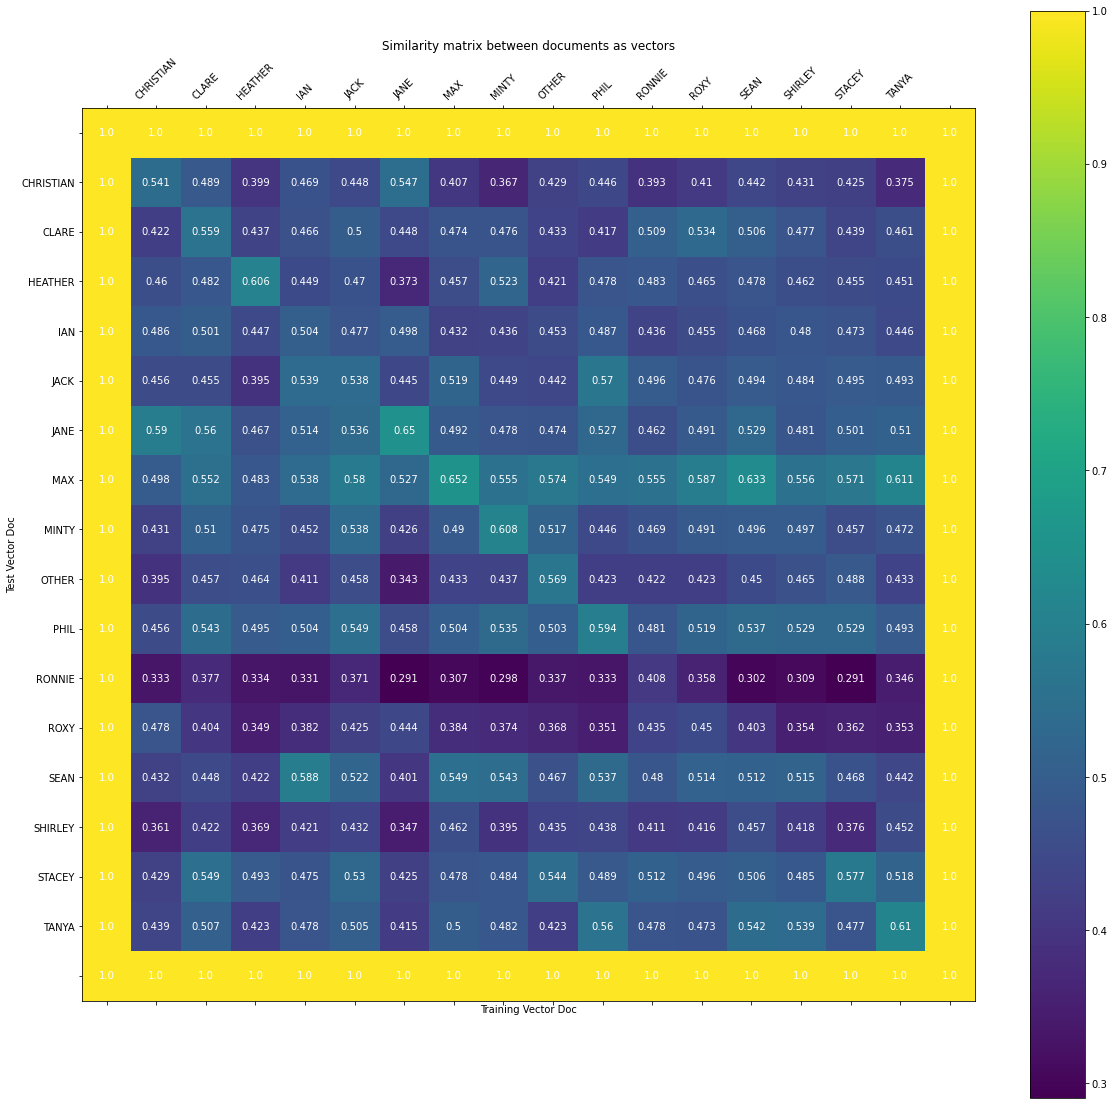

In [23]:
plot_heat_map_similarity(df)

# Q2. Improve linguistic feature extraction (15 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

- include POS tags
- ngrams (use bigrams and trigrams)

In [24]:
# Rewriting the to_feature_vector_dictionary function

import nltk
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    
    tags = nltk.pos_tag(character_doc)
    postags = [', '.join(i) for i in tags]

    print (postags)
    return postags

# Q3. Add dialogue context data and features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). You can also use **scene information** from the other columns **(but NOT the gender and character names directly)**.

- Adding information about the episode and scene

In [25]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender, scene, episode in zip(df.Line, df.Character_name, df.Gender, df.Scene, df.Episode):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(episode) + "_" + str(scene) + " " + str(line) + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    #print("lines per character", character_line_count)
    
    print (character_docs)
    return character_docs

# Q4. Improve the vectorization method (10 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

- Going from a DictVectorizer to TF-IDF

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_tokenizer(doc):
    return doc

tfidfVectorizer = tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_tokenizer,
    preprocessor=dummy_tokenizer,
    token_pattern=None)

def create_document_matrix_from_corpus(corpus, fitting=False):

    docs = [to_feature_vector_dictionary(doc) for name, doc in corpus]
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        tfidfVectorizer.fit(docs)
    doc_feature_matrix = tfidfVectorizer.transform(docs)
    
    #training_feature_matrix[0].toarray()

    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)


['lesley, NN', 'really, RB', 'glad, JJ', 'must, MD', 'ian, JJ', 'partner, NN', 'ashley, NN', 'lovely, RB', 'little, JJ', 'place, NN', 'seen, VBN', 'flesh, JJ', 'ashley, NN', 'lesley, NN', 'compare, VBP', 'way, NN', 'described, JJ', 'keep, VB', 'forgetting, VBG', 'lesley, RB', 'changed, VBN', 'name, NN', 'would, MD', 'therapist, VB', 'bloke, NNS', 'make, VB', 'might, MD', 'say, VB', 'indicates, NNS', 'attempt, JJ', 'run, VBP', 'away, RB', 'something, NN', 'let, JJ', 'go, VB', 'amongst, JJ', 'thing, NN', 'sister, NN', 'called, VBN', 'love, NN', 'hate, NN', 'relationship, NN', 'love, VBP', 'hate, NN', 'right, JJ', 'jane, NN', 'love, RB', 'much, JJ', 'break, IN', 'heart, NN', 'bottle, NN', 'best, JJS', 'champagne, NN', 'please, VB', 'start, JJ', 'counting, VBG', 'penny, JJ', 'jane, NN', 'paying, VBG', 'ash, NN', 'know, VBP', 'ian, JJ', 'exactly, RB', 'imagined, VBN', 'say, VBP', 'ash, JJ', 'kind, NN', 'bloke, VBD', 'jane, NN', 'would, MD', 'end, VB', 'marrying, VBG', 'mean, JJ', 'david, NN

['want, NN', 'go, VBP', 'home, NN', 'someone, NN', 'waiting, VBG', 'see, NN', 'know, VBP', 'know, VB', 'tell, NN', 'called, VBN', 'somewhere, RB', 'dunno, RB', 'tell, VB', 'gonna, NN', 'answer, NN', 'sorry, NN', 'shirl, JJ', 'manage, NN', 'alright, VBD', 'nothing, NN', 'know, VBP', 'vinnie, NN', 'like, IN', 'mean, JJ', 'see, VBP', 'future, JJ', 'together, RB', 'mill, NN', 'lately, RB', 'wanna, VBD', 'see, VB', 'get, JJ', 'hurt, VBN', 'yeah, RB', 'vinnie, IN', 'telling, VBG', 'whole, JJ', 'truth, NN', 'might, MD', 'wrong, VB', 'hope, NN', 'think, VBP', 'sorry, JJ', 'shirl, NN', 'think, VBP', 'married, VBN', 'sorry, JJ', 'get, VB', 'u, JJ', 'fish, JJ', 'chip, NN', 'celebrate, NN', 'oi, NN', 'help, NN', 'help, VB', 'quick, VB', 'making, VBG', 'citizen, JJ', 'arrest, NN', 'nicked, VBD', 'call, JJ', 'old, JJ', 'bill, NN', 'nicking, VBG', 'car, NN', 'like, IN', 'one, CD', 'candid, NN', 'camera, NN', 'thing, NN', 'worth, JJ', 'shirl, NN', 'surprised, VBD', 'brick, JJ', 'let, NN', 'think, VB',

['oi, NN', 'huh, NN', 'text, NN', 'well, RB', 'got, VBD', 'mate, RB', 'wanted, VBN', 'chat, NN', 'instead, RB', 'serving, VBG', 'behind, IN', 'bar, NN', 'house, NN', 'alright, VBD', 'left, VBN', 'night, NN', 'wallet, NN', 'home, NN', 'gonna, NN', 'ten, IN', 'minute, JJ', 'alright, JJ', 'bit, NN', 'since, IN', 'got, VBD', 'late, JJ', 'little, JJ', 'set, NN', 'planned, VBN', 'well, RB', 'pour, JJ', 'glass, NNS', 'take, VB', 'might, MD', 'happened, VB', 'would, MD', 'given, VBN', 'fair, VB', 'do, VBP', 'think, VB', 'talk, VB', 'laugh, IN', 'moment, NN', 'would, MD', 'come, VB', 'moment, NN', 'close, RB', 'friend, VBP', 'one, CD', 'smell, NN', 'perfume, NN', 'skin, JJ', 'wonder, NN', 'brave, VBP', 'enough, JJ', 'tea, NN', 'nice, JJ', 'hotel, NN', 'far, RB', 'go, VBP', 'one, CD', 'like, IN', 'cheating, VBG', 'tanya, RB', 'much, JJ', 'got, VBD', 'perfectly, RB', 'good, JJ', 'house, NN', 'royally, RB', 'screwed, VBD', 'go, VB', 'stay, JJ', 'care, NN', 'put, VBD', 'shut, JJ', 'sure, JJ', 'sayi

['want, JJ', 'talk, NN', 'sean, NN', 'losing, VBG', 'going, VBG', 'bit, NN', 'tcha, JJ', 'vodka, JJ', 'lecture, NN', 'know, VBP', 'give, JJ', 'anything, NN', 'change, NN', 'know, VBP', 'never, RB', 'believe, VBP', 'mean, JJ', 'come, VBP', 'bradley, NN', 'stupid, JJ', 'bradley, NN', 'done, VBN', 'pain, NN', 'caused, VBN', 'excuse, IN', 'family, NN', 'everything, NN', 'love, NN', 'mine, NN', 'make, VBP', 'right, JJ', 'swear, JJ', 'god, NN', 'already, RB', 'hey, VBZ', 'gorgeous, JJ', 'dot, JJ', 'tan, NN', 'know, VBP', 'mean, JJ', 'happens, NNS', 'stop, VB', 'wanna, NN', 'go, VBP', 'road, NN', 'start, NN', 'getting, VBG', 'court, NN', 'involved, VBN', 'draw, JJ', 'attention, NN', 'unfit, NN', 'mother, NN', 'obsessed, VBD', 'career, NN', 'abi, NNS', 'nearly, RB', 'suffered, VBD', 'crippling, JJ', 'injury, NN', 'busy, JJ', 'opening, VBG', 'little, JJ', 'shop, JJ', 'negligence, NN', 'like, IN', 'negligence, NN', 'almost, RB', 'killed, VBD', 'unborn, JJ', 'child, NN', 'ambulance, NN', 'preferr

['yes, NNS', 'got, VBD', 'worry, JJ', 'come, JJ', 'thanks, NNS', 'seeing, VBG', 'bloke, NN', 'later, RB', 'jack, NN', 'look, NN', 'care, NN', 'pair, NN', 'get, VB', 'long, RB', 'distracted, JJ', 'real, JJ', 'business, NN', 'hand, NN', 'finding, VBG', 'louise, NN', 'see, VBP', 'make, JJ', 'sure, JJ', 'top, JJ', 'agenda, NN', 'asking, VBG', 'member, NN', 'family, NN', 'louise, NN', 'get, NN', 'home, NN', 'yet, RB', 'mate, JJ', 'youneed, NN', 'sorting, VBG', 'much, JJ', 'drink, NN', 'much, JJ', 'drink, NN', 'gonna, NN', 'embarrass, NN', 'eh, NN', 'bring, VBG', 'middle, JJ', 'funeral, JJ', 'yeah, NN', 'picking, VBG', 'car, NN', 'dave, VB', 'stanway, RB', 'much, JJ', 'better, JJR', 'photo, NN', 'sat, VBD', 'outside, IN', 'flat, JJ', 'car, NN', 'dunno, NN', 'plan, NN', 'wanted, VBD', 'see, NN', 'living, VBG', 'poxy, JJ', 'little, JJ', 'flat, JJ', 'brother, NN', 'see, VBP', 'eye, NN', 'talk, NN', 'lisa, VBZ', 'like, IN', 'see, NN', 'try, NN', 'get, VB', 'chance, NN', 'like, IN', 'sniff, JJ', 

['surprised, JJ', 'ask, NN', 'going, VBG', 'spell, RB', 'really, RB', 'know, VB', 'treat, NN', 'girl, NNS', 'right, RB', 'jase, VBP', 'new, JJ', 'year, NN', 'eve, VBP', 'text, IN', 'call, NN', 'plan, NN', 'thing, NN', 'telepathy, JJ', 'thought, NN', 'might, MD', 'served, VB', 'something, NN', 'bit, NN', 'posher, JJ', 'fish, JJ', 'supper, NN', 'obviously, RB', 'pick, JJ', 'radar, NN', 'know, VBP', 'skating, VBG', 'thin, JJ', 'ice, NN', 'dyer, NN', 'saying, VBG', 'subject, JJ', 'hello, NN', 'got, VBD', 'text, JJ', 'phil, NN', 'let, NN', 'knock, VB', 'early, JJ', 'oh, NN', 'oh, MD', 'see, VB', 'like, IN', 'jase, NN', 'texted, VBN', 'oi, JJ', 'come, JJ', 'apologise, RB', 'well, RB', 'late, RB', 'cause, NN', 'someone, NN', 'else, RB', 'scene, VBZ', 'come, VBN', 'problem, NN', 'miss, NN', '99p, CD', 'knickers, NNS', 'think, VBP', 'bird, NN', 'club, NN', 'blame, NN', 'jase, NN', 'get, VB', 'jase, NN', 'chucked, VBN', 'timbuktu, JJ', 'oh, JJ', 'screw, VBD', 'everything, NN', 'oh, RP', 'already

['look, NN', 'ya, PRP', 'mark, VBP', 'ya, JJ', 'think, VBP', 'unlucky, JJ', 'man, NN', 'gonna, NN', 'get, VB', 'help, NN', 'oh, VB', 'phone, NN', 'oh, JJ', 'kevin, NN', 'kevin, NN', 'smashed, VBD', 'ya, RB', 'kevin, JJ', 'kevin, NN', 'phone, NN', 'ssh, NN', 'shut, NN', 'fire, NN', 'brigade, VBD', 'ambulance, JJ', 'accident, JJ', 'industrial, JJ', 'estate, NN', 'walford, NN', 'um, NN', 'marsh, NN', 'lane, JJ', 'industrial, JJ', 'estate, NN', 'please, NN', 'come, VB', 'quick, JJ', 'husband, NN', 'husband, NN', 'friend, NN', 'trapped, VBD', 'car, NN', 'please, NN', 'come, VB', 'quick, JJ', 'shirley, NN', 'carter, NN', '82, CD', '82b, CD', 'george, NN', 'street, NN', 'walford, NN', 'e20, VBZ', 'please, JJ', 'hurry, JJ', 'please, NN', 'come, VB', 'quick, JJ', 'kevin, NN', 'kevin, NN', 'kevin, NN', 'gonna, NN', 'go, VBP', 'main, JJ', 'road, NN', 'make, VBP', 'sure, NN', 'know, VB', 'go, VBP', 'kevin, JJ', 'five, CD', 'minute, JJ', 'fine, NN', 'talking, VBG', 'five, CD', 'minute, NN', 'alrigh

['another, DT', 'drink, NN', 'lightweight, VBD', 'let, NN', 'see, NN', 'got, VBD', 'shall, MD', 'oh, VB', 'look, NN', '21, CD', 'year, NN', 'old, JJ', 'whisky, NN', 'let, VBD', 'shall, MD', 'max, VB', 'prefers, NNS', 'younger, JJR', 'seany, JJ', 'sean, JJ', 'sean, JJ', 'point, NN', 'going, VBG', 'bed, VBD', 'early, JJ', 'new, JJ', 'year, NN', 'eve, VBP', 'yep, NN', 'well, RB', 'wanted, VBD', 'u, JJ', 'together, RB', 'mother, NN', 'perogative, JJ', 'go, VBP', 'get, VB', 'jim, JJ', 'jam, NN', 'watch, NN', 'big, JJ', 'ben, NN', 'together, RB', 'tub, JJ', 'ice, NN', 'cream, NN', 'bye, NN', 'want, VBP', 'hear, NN', 'crap, NN', 'get, VBP', 'house, NN', 'max, NN', 'scream, NN', 'think, NN', 'said, VBD', 'get, VBP', 'want, JJ', 'coming, VBG', 'boxed, JJ', 'set, NN', 'count, NN', 'one, CD', 'choice, NN', 'young, JJ', 'lady, NN', 'yes, RB', 'speaking, VBG', 'believe, VBP', 'okay, NN', 'right, RB', 'getting, VBG', 'dressed, VBN', 'someone, NN', 'broke, VBD', 'salon, NN', 'last, JJ', 'night, NN', 

In [27]:
# Implementation

# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
#print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
#    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
#print("total words", total_words)


# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
#print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
#    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
#print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]




training_feature_matrix_q4 = create_document_matrix_from_corpus(training_corpus, fitting=True)
val_feature_matrix_q4 = create_document_matrix_from_corpus(val_corpus, fitting=False)
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix_q4, val_feature_matrix_q4, train_labels, val_labels)


{'SHIRLEY': '1350_1 Look at ya, not a mark on ya. And you think you\'re an unlucky man. _EOL_ 1350_4 I\'m gonna get help. Oh where\'s my phone? Oh Kevin. Kevin you smashed it, didn\'t ya? Kevin, Kevin, where\'s your phone? _EOL_ 1350_4 No you\'re not, ssh, shut up. _EOL_ 1350_4 Fire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he\'s not my husband- my friend. He\'s trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick. _EOL_ 1350_4 Kevin. Kevin! _EOL_ 1350_4 Kevin I\'m gonna go to the main road - _EOL_ 1350_4 To make sure they know where to go. _EOL_ 1350_4 Kevin I\'ll be five minutes. _EOL_ 1350_4 You\'ll be fine. You\'re talking. I\'ll be five minutes. _EOL_ 1350_4 It\'s alright, it\'s alright, it\'s alright, it\'s alright. _EOL_ 1350_27 Go away. _EOL_ 1350_27 I don\'t know what to say. It\'s a nightmar

['lesley, NN', 'really, RB', 'glad, JJ', 'must, MD', 'ian, JJ', 'partner, NN', 'ashley, NN', 'lovely, RB', 'little, JJ', 'place, NN', 'seen, VBN', 'flesh, JJ', 'ashley, NN', 'lesley, NN', 'compare, VBP', 'way, NN', 'described, JJ', 'keep, VB', 'forgetting, VBG', 'lesley, RB', 'changed, VBN', 'name, NN', 'would, MD', 'therapist, VB', 'bloke, NNS', 'make, VB', 'might, MD', 'say, VB', 'indicates, NNS', 'attempt, JJ', 'run, VBP', 'away, RB', 'something, NN', 'let, JJ', 'go, VB', 'amongst, JJ', 'thing, NN', 'sister, NN', 'called, VBN', 'love, NN', 'hate, NN', 'relationship, NN', 'love, VBP', 'hate, NN', 'right, JJ', 'jane, NN', 'love, RB', 'much, JJ', 'break, IN', 'heart, NN', 'bottle, NN', 'best, JJS', 'champagne, NN', 'please, VB', 'start, JJ', 'counting, VBG', 'penny, JJ', 'jane, NN', 'paying, VBG', 'ash, NN', 'know, VBP', 'ian, JJ', 'exactly, RB', 'imagined, VBN', 'say, VBP', 'ash, JJ', 'kind, NN', 'bloke, VBD', 'jane, NN', 'would, MD', 'end, VB', 'marrying, VBG', 'mean, JJ', 'david, NN

['dot, NN', 'dot, NN', 'dot, NN', 'people, NNS', 'still, RB', 'use, VBP', 'place, NN', 'pauline, NN', 'something, NN', 'like, IN', 'waiting, VBG', 'someone, NN', 'fella, NN', 'run, VB', 'place, NN', 'still, RB', 'live, JJ', 'round, NN', 'bit, NN', 'comedown, JJ', 'one, CD', 'remember, NN', 'bacon, NN', 'sandwich, JJ', 'please, NN', 'really, RB', 'listen, JJ', 'er, VBP', 'suppose, NN', 'could, MD', 'lend, VB', 'cash, NN', 'ya, NN', 'get, VB', 'pauline, JJ', 'come, VBN', 'ian, JJ', 'chucked, VBN', 'sonia, NN', 'cafe, JJ', 'enough, JJ', 'time, NN', 'little, JJ', 'tried, JJ', 'call, NN', 'dot, NN', 'boyfriend, NN', 'ex, NN', 'boyfriend, VBP', 'need, NN', 'somewhere, RB', 'clean, JJ', 'please, NN', 'ian, JJ', 'got, VBD', 'nowhere, RB', 'else, RB', 'go, VBP', 'mean, JJ', 'soon, RB', 'got, VBD', 'cash, NN', 'next, IN', 'train, NN', 'look, NN', 'gotta, NN', 'go, VBP', 'sorry, JJ', 'hope, NN', 'mind, NN', 'alright, JJ', 'ian, JJ', 'seem, VBP', 'bit, RB', 'flustered, JJ', 'pauline, NN', 'old, JJ

['want, NN', 'go, VBP', 'home, NN', 'someone, NN', 'waiting, VBG', 'see, NN', 'know, VBP', 'know, VB', 'tell, NN', 'called, VBN', 'somewhere, RB', 'dunno, RB', 'tell, VB', 'gonna, NN', 'answer, NN', 'sorry, NN', 'shirl, JJ', 'manage, NN', 'alright, VBD', 'nothing, NN', 'know, VBP', 'vinnie, NN', 'like, IN', 'mean, JJ', 'see, VBP', 'future, JJ', 'together, RB', 'mill, NN', 'lately, RB', 'wanna, VBD', 'see, VB', 'get, JJ', 'hurt, VBN', 'yeah, RB', 'vinnie, IN', 'telling, VBG', 'whole, JJ', 'truth, NN', 'might, MD', 'wrong, VB', 'hope, NN', 'think, VBP', 'sorry, JJ', 'shirl, NN', 'think, VBP', 'married, VBN', 'sorry, JJ', 'get, VB', 'u, JJ', 'fish, JJ', 'chip, NN', 'celebrate, NN', 'oi, NN', 'help, NN', 'help, VB', 'quick, VB', 'making, VBG', 'citizen, JJ', 'arrest, NN', 'nicked, VBD', 'call, JJ', 'old, JJ', 'bill, NN', 'nicking, VBG', 'car, NN', 'like, IN', 'one, CD', 'candid, NN', 'camera, NN', 'thing, NN', 'worth, JJ', 'shirl, NN', 'surprised, VBD', 'brick, JJ', 'let, NN', 'think, VB',

['perhaps, RB', 'cook, VB', 'something, NN', 'like, IN', 'martin, NN', 'auntie, JJ', 'pauline, NN', 'know, VBP', 'something, NN', 'like, IN', 'holiday, NN', 'new, JJ', 'year, NN', 'never, RB', 'plus, CC', 'going, VBG', 'moving, VBG', 'today, NN', 'maybe, RB', 'later, RB', 'week, NN', 'le, JJ', 'apology, NN', 'happened, VBD', 'kevin, NNS', 'made, VBN', 'realise, NN', 'know, NNS', 'take, VBP', 'stuff, NN', 'granted, VBN', 'know, VBP', 'found, VBN', 'christmas, VBP', 'tough, JJ', 'make, NN', 'tougher, NN', 'kid, NN', 'jane, NN', 'sorry, JJ', 'face, NN', 'fried, VBD', 'thousand, CD', 'chip, NN', 'believe, VBP', 'ronnie, NN', 'mitchell, NN', 'steal, VB', 'catering, VBG', 'kevin, JJ', 'funeral, JJ', 'come, NN', 'borrow, NN', 'egg, NN', 'slicer, NN', 'mean, VBP', 'sort, NN', 'caterer, NN', 'basic, JJ', 'equipment, NN', 'got, VBD', 'put, VBN', 'buffet, RB', 'pace, NN', 'later, RB', 'probe, NN', 'weakness, NN', 'steven, VBN', 'see, VBP', 'people, NNS', 'say, VBP', 'understand, JJ', 'woman, NN',

['oi, NN', 'huh, NN', 'text, NN', 'well, RB', 'got, VBD', 'mate, RB', 'wanted, VBN', 'chat, NN', 'instead, RB', 'serving, VBG', 'behind, IN', 'bar, NN', 'house, NN', 'alright, VBD', 'left, VBN', 'night, NN', 'wallet, NN', 'home, NN', 'gonna, NN', 'ten, IN', 'minute, JJ', 'alright, JJ', 'bit, NN', 'since, IN', 'got, VBD', 'late, JJ', 'little, JJ', 'set, NN', 'planned, VBN', 'well, RB', 'pour, JJ', 'glass, NNS', 'take, VB', 'might, MD', 'happened, VB', 'would, MD', 'given, VBN', 'fair, VB', 'do, VBP', 'think, VB', 'talk, VB', 'laugh, IN', 'moment, NN', 'would, MD', 'come, VB', 'moment, NN', 'close, RB', 'friend, VBP', 'one, CD', 'smell, NN', 'perfume, NN', 'skin, JJ', 'wonder, NN', 'brave, VBP', 'enough, JJ', 'tea, NN', 'nice, JJ', 'hotel, NN', 'far, RB', 'go, VBP', 'one, CD', 'like, IN', 'cheating, VBG', 'tanya, RB', 'much, JJ', 'got, VBD', 'perfectly, RB', 'good, JJ', 'house, NN', 'royally, RB', 'screwed, VBD', 'go, VB', 'stay, JJ', 'care, NN', 'put, VBD', 'shut, JJ', 'sure, JJ', 'sayi

['maybe, RB', 'know, VBP', 'like, IN', 'thinking, VBG', 'going, VBG', 'matter, NN', 'two, CD', 'decide, VBP', 'lucy, JJ', 'bobby, NN', 'like, IN', 'going, VBG', 'cafe, JJ', 'way, NN', 'bad, JJ', 'feeling, NN', 'go, VB', 'away, RB', 'denise, NN', 'strong, JJ', 'get, NN', 'others, NNS', 'worry, VBP', 'denise, VB', 'girl, JJ', 'ian, JJ', 'stuff, NN', 'right, NN', 'like, IN', 'said, VBD', 'something, NN', 'missing, VBG', 'spent, NN', 'lot, NN', 'time, NN', 'last, JJ', 'couple, NN', 'week, NN', 'scared, VBD', 'angry, JJ', 'know, JJ', 'matter, NN', 'none, NN', 'really, RB', 'matter, RBR', 'sitting, VBG', 'round, RBR', 'table, JJ', 'like, IN', 'enough, JJ', 'already, RB', 'something, NN', 'pat, NNS', 'said, VBD', 'important, JJ', 'let, NN', 'eat, NN', 'care, VB', 'ian, JJ', 'care, NN', 'puff, NN', 'pastry, NN', 'got, VBD', 'consistency, NN', 'brick, NN', 'care, NN', 'steven, JJ', 'steven, RB', 'yes, RB', 'steven, VBN', 'like, IN', 'inside, JJ', 'head, NN', 'sorry, NN', 'must, MD', 'go, VB', '

['want, JJ', 'talk, NN', 'sean, NN', 'losing, VBG', 'going, VBG', 'bit, NN', 'tcha, JJ', 'vodka, JJ', 'lecture, NN', 'know, VBP', 'give, JJ', 'anything, NN', 'change, NN', 'know, VBP', 'never, RB', 'believe, VBP', 'mean, JJ', 'come, VBP', 'bradley, NN', 'stupid, JJ', 'bradley, NN', 'done, VBN', 'pain, NN', 'caused, VBN', 'excuse, IN', 'family, NN', 'everything, NN', 'love, NN', 'mine, NN', 'make, VBP', 'right, JJ', 'swear, JJ', 'god, NN', 'already, RB', 'hey, VBZ', 'gorgeous, JJ', 'dot, JJ', 'tan, NN', 'know, VBP', 'mean, JJ', 'happens, NNS', 'stop, VB', 'wanna, NN', 'go, VBP', 'road, NN', 'start, NN', 'getting, VBG', 'court, NN', 'involved, VBN', 'draw, JJ', 'attention, NN', 'unfit, NN', 'mother, NN', 'obsessed, VBD', 'career, NN', 'abi, NNS', 'nearly, RB', 'suffered, VBD', 'crippling, JJ', 'injury, NN', 'busy, JJ', 'opening, VBG', 'little, JJ', 'shop, JJ', 'negligence, NN', 'like, IN', 'negligence, NN', 'almost, RB', 'killed, VBD', 'unborn, JJ', 'child, NN', 'ambulance, NN', 'preferr

['going, VBG', 'billy, RB', 'new, JJ', 'place, NN', 'space, NN', 'honey, NN', 'enjoying, VBG', 'ya, PRP', 'ﬁ, JJ', 'yeah, UH', 'billy, RB', 'round, JJ', 'clock, NN', 'lover, NN', 'ﬂ, NNP', 'yeah, CC', 'maybe, RB', 'let, VB', 'know, VB', 'eh, RB', 'wanted, JJ', 'check, NN', 'first, RB', 'gonna, VBZ', 'one, CD', 'husband, NN', 'whose, WP$', 'always, RB', 'making, VBG', 'excuse, IN', 'come, VBN', 'home, NN', 'fed, NN', 'time, NN', 'fed, VBD', 'spending, NN', 'every, DT', 'night, NN', 'mate, NN', 'wanna, NN', 'spend, VBP', 'em, NN', 'know, VBP', 'gonna, NN', 'marry, NN', 'know, VBP', 'gonna, NN', 'win, JJ', 'competition, NN', 'dunno, NN', 'whatever, WDT', 'maybe, RB', 'planning, VBG', 'certain, JJ', 'surprise, NN', 'certain, JJ', 'occasion, NN', 'oh, NN', 'got, VBD', 'magazine, NN', 'donna, NN', 'paul, VB', 'yes, UH', 'disturb, NN', 'little, JJ', 'un, JJ', 'left, VBD', 'foot, JJ', 'yellow, JJ', 'honey, NN', 'take, NN', 'go, VBP', 'stay, VB', 'like, IN', 'much, RB', 'longer, RBR', 'awful, J

['shirl, NN', 'going, VBG', 'right, JJ', 'pocket, NN', 'done, VBN', 'done, VBN', 'go, VB', 'shirl, JJ', 'going, VBG', 'make, NN', 'got, VBD', 'five, CD', 'minute, NN', 'got, VBD', 'sit, JJ', 'please, NN', 'want, VBP', 'go, VB', 'please, VB', 'shirley, JJ', 'life, NN', 'ask, NN', 'scared, VBD', 'scared, JJ', 'scared, JJ', 'phil, NN', 'said, VBD', 'alright, JJ', 'shandy, NN', 'two, CD', 'leg, NN', 'feel, VB', 'funny, JJ', 'daft, NNS', 'head, VBP', 'hardly, RB', 'anything, NN', 'one, CD', 'look, NN', 'innit, NN', 'done, VBN', 'wrong, JJ', 'come, JJ', 'gotta, NN', 'run, VBP', 'load, NN', 'option, NN', 'head, NN', 'oh, IN', 'come, JJ', 'thought, NN', 'working, VBG', 'lost, VBN', 'know, JJ', 'roxy, NN', 'plank, NN', 'get, VB', 'u, JJ', 'another, DT', 'pint, NN', 'tell, NN', 'schoolboy, JJ', 'mistake, NN', 'room, NN', 'yeah, NN', 'course, NN', 'darling, VBG', 'get, VB', 'drink, JJ', 'come, VBN', 'sit, NN', 'u, JJ', 'think, VBP', 'shirley, VBP', 'gone, VBN', 'home, NN', 'acting, VBG', 'weird, 

['nothing, NN', 'nothing, NN', 'two, CD', 'minute, NN', 'yeah, NNS', 'alright, VBD', 'two, CD', 'minute, NN', 'okay, FW', 'proper, JJ', 'little, JJ', 'detective, JJ', 'drunk, NN', 'work, NN', 'jack, NN', 'bode, NN', 'moment, NN', 'oi, NN', 'hell, NN', 'going, VBG', 'listen, JJ', 'spoiling, VBG', 'night, NN', 'home, NN', 'get, NN', 'course, NN', 'sorry, JJ', 'jase, NN', 'think, VBP', 'got, VBD', 'someone, NN', 'line, NN', 'already, RB', 'nah, RB', 'keep, VB', '2008, CD', 'best, JJS', 'year, NN', 'yet, RB', 'course, NN', 'know, VBP', 'better, JJR', 'reason, NN', 'whose, WP$', 'fault, NN', 'usually, RB', 'sell, VBP', 'date, NN', 'clue, NN', 'notice, JJ', 'let, NN', 'cook, VB', 'take, VB', 'look, NN', 'think, VBP', 'good, JJ', 'idea, NN', 'fine, NN', 'right, NN', 'said, VBD', 'go, VBP', 'go, VB', 'prawn, RB', 'bad, JJ', 'well, RB', 'expected, VBN', 'thanks, NNS', 'auntie, VBP', 'peg, NN', 'got, VBD', 'bloke, JJ', 'meeting, NN', 'business, NN', 'yes, RB', 'sure, JJ', 'like, IN', 'way, NN', 


['surprised, JJ', 'ask, NN', 'going, VBG', 'spell, RB', 'really, RB', 'know, VB', 'treat, NN', 'girl, NNS', 'right, RB', 'jase, VBP', 'new, JJ', 'year, NN', 'eve, VBP', 'text, IN', 'call, NN', 'plan, NN', 'thing, NN', 'telepathy, JJ', 'thought, NN', 'might, MD', 'served, VB', 'something, NN', 'bit, NN', 'posher, JJ', 'fish, JJ', 'supper, NN', 'obviously, RB', 'pick, JJ', 'radar, NN', 'know, VBP', 'skating, VBG', 'thin, JJ', 'ice, NN', 'dyer, NN', 'saying, VBG', 'subject, JJ', 'hello, NN', 'got, VBD', 'text, JJ', 'phil, NN', 'let, NN', 'knock, VB', 'early, JJ', 'oh, NN', 'oh, MD', 'see, VB', 'like, IN', 'jase, NN', 'texted, VBN', 'oi, JJ', 'come, JJ', 'apologise, RB', 'well, RB', 'late, RB', 'cause, NN', 'someone, NN', 'else, RB', 'scene, VBZ', 'come, VBN', 'problem, NN', 'miss, NN', '99p, CD', 'knickers, NNS', 'think, VBP', 'bird, NN', 'club, NN', 'blame, NN', 'jase, NN', 'get, VB', 'jase, NN', 'chucked, VBN', 'timbuktu, JJ', 'oh, JJ', 'screw, VBD', 'everything, NN', 'oh, RP', 'alread

['pretty, RB', 'wasted, VBN', 'go, VBP', 'penny, JJ', 'tanya, NNS', 'come, VBP', 'want, VBP', 'leave, JJ', 'thing, NN', 'like, IN', 'last, JJ', 'night, NN', 'thought, VBD', 'important, JJ', 'got, VBD', 'vital, JJ', 'meeting, NN', 'left, VBD', 'heated, VBN', 'curler, NN', 'overnight, JJ', 'designer, NN', 'charge, NN', 'fortune, VBD', 'come, JJ', 'look, NN', 'sorry, NN', 'earlier, RBR', 'thinking, VBG', 'someone, NN', 'fun, NN', 'need, VBP', 'help, NN', 'leave, VB', 'key, JJ', 'see, VB', 'magic, JJ', 'everything, NN', 'back, RB', 'normal, JJ', 'like, IN', 'nothing, NN', 'ever, RB', 'happened, VBD', 'pretty, RB', 'much, JJ', 'anyway, RB', 'see, VBP', 'tomorrow, NN', 'tanya, NN', 'want, VBP', 'beautiful, JJ', 'stupid, NN', 'know, VBP', 'going, VBG', 'anywhere, RB', 'look, VBP', 'like, IN', 'hungry, JJ', 'want, VBP', 'wake, JJ', 'course, NN', 'good, JJ', 'appetite, NN', 'mum, NN', 'would, MD', 'call, VB', 'proper, JJ', 'little, JJ', 'trencherman, JJ', 'idea, NN', 'like, IN', 'still, RB', 'g

['look, NN', 'ya, PRP', 'mark, VBP', 'ya, JJ', 'think, VBP', 'unlucky, JJ', 'man, NN', 'gonna, NN', 'get, VB', 'help, NN', 'oh, VB', 'phone, NN', 'oh, JJ', 'kevin, NN', 'kevin, NN', 'smashed, VBD', 'ya, RB', 'kevin, JJ', 'kevin, NN', 'phone, NN', 'ssh, NN', 'shut, NN', 'fire, NN', 'brigade, VBD', 'ambulance, JJ', 'accident, JJ', 'industrial, JJ', 'estate, NN', 'walford, NN', 'um, NN', 'marsh, NN', 'lane, JJ', 'industrial, JJ', 'estate, NN', 'please, NN', 'come, VB', 'quick, JJ', 'husband, NN', 'husband, NN', 'friend, NN', 'trapped, VBD', 'car, NN', 'please, NN', 'come, VB', 'quick, JJ', 'shirley, NN', 'carter, NN', '82, CD', '82b, CD', 'george, NN', 'street, NN', 'walford, NN', 'e20, VBZ', 'please, JJ', 'hurry, JJ', 'please, NN', 'come, VB', 'quick, JJ', 'kevin, NN', 'kevin, NN', 'kevin, NN', 'gonna, NN', 'go, VBP', 'main, JJ', 'road, NN', 'make, VBP', 'sure, NN', 'know, VB', 'go, VBP', 'kevin, JJ', 'five, CD', 'minute, JJ', 'fine, NN', 'talking, VBG', 'five, CD', 'minute, NN', 'alrigh

['would, MD', 'gallon, VB', 'half, NN', 'water, NN', 'drank, NN', 'worry, VBP', 'drank, JJ', 'plenty, NN', 'letting, VBG', 'hair, NN', 'new, JJ', 'year, NN', 'eve, VBP', 'remember, NN', 'last, JJ', 'lister, NN', 'looking, VBG', 'think, VBP', 'come, VBN', 'important, JJ', 'bradley, NN', 'sorry, NN', 'mean, NN', 'said, VBD', 'always, RB', 'discount, NN', 'call, NN', 'liar, NN', 'right, JJ', 'reckon, NN', 'sean, JJ', 'steven, RB', 'mind, VBP', 'stall, JJ', 'half, JJ', 'hour, NN', 'look, NN', 'tell, VB', 'yes, RB', 'bradley, NN', 'saw, VBD', 'mum, NN', 'said, VBD', 'leaving, VBG', 'true, JJ', 'know, NNS', 'go, VBP', 'go, VB', 'going, VBG', 'cause, NN', 'leave, VBP', 'stay, VBN', 'little, JJ', 'mo, NN', 'freddy, NNS', 'give, VBP', 'week, NN', 'two, CD', 'chance, NN', 'think, VBP', 'thing, NN', 'going, VBG', 'well, RB', 'angry, JJ', 'maybe, RB', 'chance, NN', 'know, VBP', 'chance, NN', 'talk, NN', 'properly, RB', 'going, VBG', 'kicked, JJ', 'course, NN', 'see, VBP', 'coming, VBG', 'back, RB'

['another, DT', 'drink, NN', 'lightweight, VBD', 'let, NN', 'see, NN', 'got, VBD', 'shall, MD', 'oh, VB', 'look, NN', '21, CD', 'year, NN', 'old, JJ', 'whisky, NN', 'let, VBD', 'shall, MD', 'max, VB', 'prefers, NNS', 'younger, JJR', 'seany, JJ', 'sean, JJ', 'sean, JJ', 'point, NN', 'going, VBG', 'bed, VBD', 'early, JJ', 'new, JJ', 'year, NN', 'eve, VBP', 'yep, NN', 'well, RB', 'wanted, VBD', 'u, JJ', 'together, RB', 'mother, NN', 'perogative, JJ', 'go, VBP', 'get, VB', 'jim, JJ', 'jam, NN', 'watch, NN', 'big, JJ', 'ben, NN', 'together, RB', 'tub, JJ', 'ice, NN', 'cream, NN', 'bye, NN', 'want, VBP', 'hear, NN', 'crap, NN', 'get, VBP', 'house, NN', 'max, NN', 'scream, NN', 'think, NN', 'said, VBD', 'get, VBP', 'want, JJ', 'coming, VBG', 'boxed, JJ', 'set, NN', 'count, NN', 'one, CD', 'choice, NN', 'young, JJ', 'lady, NN', 'yes, RB', 'speaking, VBG', 'believe, VBP', 'okay, NN', 'right, RB', 'getting, VBG', 'dressed, VBN', 'someone, NN', 'broke, VBD', 'salon, NN', 'last, JJ', 'night, NN', 

['1372_27, CD', 'right, RB', 'well, RB', 'chat, RB', 'really, RB', 'sorry, JJ', 'chelsea, NN', '1372_27, CD', 'promise, NN', '1372_27, CD', 'look, NN', 'tanya, NN', 'fault, NN', '1372_27, CD', 'talked, VBD', 'first, RB', 'really, RB', 'sorry, JJ', '1373_28, CD', 'well, RB', 'say, VB', '1373_28, CD', 'tanya, NNS', 'told, VBD', '1373_28, CD', 'blame, NN', 'fact, NN', 'even, RB', 'phone, NN', 'electrician, NN', 'without, IN', 'help, NN', '1373_28, CD', 'tanya, NN', 'let, NN', 'go, VB', 'messed, JJ', '1373_28, CD', 'like, IN', 'chance, NN', 'put, VBD', 'right, JJ', 'fact, NN', 'insist, JJ', 'husband, NN', 'put, VBD', 'awkward, JJ', 'situation, NN', 'want, VBP', 'apologise, NN', 'face, NN', '1374_33, CD', 'see, NN', 'already, RB', 'bradley, VB', 'max, NN', 'jack, NN', 'well, RB', 'trying, VBG', 'make, VB', 'way, NN', 'throguh, JJ', 'whole, JJ', 'family, NN', '1374_33, CD', 'live, JJ', 'dot, NN', '1374_33, CD', 'gonna, NN', 'go, VB', 'speak, JJ', 'jack, NN', 'see, VBP', 'apologise, RB', 'beh

['1353_12, CD', 'news, NN', 'louise, NN', '1353_12, CD', '1353_12, CD', 'grateful, JJ', 'tell, RB', 'give, VBP', 'contact, NN', 'detail, NN', 'whoever, NN', 'got, VBD', 'working, VBG', '1353_12, CD', '1353_12, CD', 'well, RB', 'sound, IN', 'like, IN', 'need, NN', 'bit, NN', 'motivation, JJ', 'need, VBP', 'money, NN', 'money, NN', '1360_19, CD', 'way, NN', 'go, VBP', 'yeah, JJ', 'pay, NN', 'work, NN', 'work, NN', 'pay, NN', 'system, NN', 'soomer, JJ', 'get, VB', 'head, JJ', 'round, NN', 'sooner, RBR', 'start, VBP', 'getting, VBG', '1360_19, CD', 'mean, JJ', 'bad, JJ', 'day, NN', 'pay, VB', '1360_19, CD', 'listen, JJ', 'listen, NNS', 'know, VBP', 'going, VBG', 'feeling, VBG', 'bit, NN', 'taken, VBN', 'granted, VBD', '1360_19, CD', 'oi, JJ', 'oi, JJ', 'oi, NN', 'think, VBP', 'going, VBG', 'eh, RB', '1360_19, CD', 'getting, VBG', 'motor, NN', 'done, VBN', 'lunchtime, JJ', 'get, NN', 'come, VBN', 'get, VBP', '1367_14, CD', 'well, RB', 'talk, NN', 'instead, RB', 'moaning, VBG', '1367_14, CD'

['1350_18, CD', 'right, JJ', 'word, NN', '1350_18, CD', 'busy, JJ', '1350_18, CD', 'wanted, VBD', '1350_18, CD', 'oh, JJ', 'yeah, NN', 'yeah, NN', 'yeah, NN', 'yeah, NN', 'cause, NN', 'moral, JJ', 'majority, NN', 'max, VBP', '1355_15, CD', 'tea, NN', '1355_15, CD', 'tea, NN', '1355_15, CD', 'mood, NN', 'kid, VBD', '1355_15, CD', '1355_15, CD', 'open, JJ', 'big, JJ', 'gob, NN', '1355_15, CD', 'told, VBD', 'party, NN', 'want, VBP', 'anyone, NN', 'else, RB', 'happy, JJ', '1355_15, CD', 'talk, NN', 'like, IN', 'one, CD', 'thing, NN', 'worth, NN', 'something, NN', 'trash, JJ', '1355_15, CD', 'could, MD', 'dropped, VB', 'big, JJ', 'time, NN', '1355_15, CD', 'stopped, VBD', 'marriage, NN', 'show, NN', 'vic, VBD', 'even, RB', 'better, RBR', 'church, NN', 'yeah, RB', 'give, JJ', 'work, NN', 'thinking, VBG', 'stace, NN', '1374_33, CD', 'stace, NN', 'slow, JJ', 'eh, NN', '1374_33, CD', 'look, NN', 'alright, VBD', '1374_33, CD', 'well, RB', 'let, VB', 'try, VB', 'catch, VB', 'much, JJ', 'fun, NN',

#### Adding Bi-grams



In [28]:

# Rewriting the to_feature_vector_dictionary function

import nltk
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    n_grams = ngrams(character_doc, 2)
    nGrams = [ ' '.join(grams) for grams in n_grams]
    
    
    tags = nltk.pos_tag(nGrams)
    postags = [', '.join(i) for i in tags]

    print (postags)
    return postags



# ----------- Running the updated function on our training + validation data -----------------------------

# Implementation

# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
#print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
#    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
#print("total words", total_words)


# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
#print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
#    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
#print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]




training_feature_matrix_q4_b = create_document_matrix_from_corpus(training_corpus, fitting=True)
val_feature_matrix_q4_b = create_document_matrix_from_corpus(val_corpus, fitting=False)
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix_q4_b, val_feature_matrix_q4_b, train_labels, val_labels)


{'SHIRLEY': '1350_1 Look at ya, not a mark on ya. And you think you\'re an unlucky man. _EOL_ 1350_4 I\'m gonna get help. Oh where\'s my phone? Oh Kevin. Kevin you smashed it, didn\'t ya? Kevin, Kevin, where\'s your phone? _EOL_ 1350_4 No you\'re not, ssh, shut up. _EOL_ 1350_4 Fire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he\'s not my husband- my friend. He\'s trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick. _EOL_ 1350_4 Kevin. Kevin! _EOL_ 1350_4 Kevin I\'m gonna go to the main road - _EOL_ 1350_4 To make sure they know where to go. _EOL_ 1350_4 Kevin I\'ll be five minutes. _EOL_ 1350_4 You\'ll be fine. You\'re talking. I\'ll be five minutes. _EOL_ 1350_4 It\'s alright, it\'s alright, it\'s alright, it\'s alright. _EOL_ 1350_27 Go away. _EOL_ 1350_27 I don\'t know what to say. It\'s a nightmar

['1363_12', 'cheap', 'aftershave', 'think', 'running', 'chip', 'shop', 'nut', '1363_12', 'ian', 'beale', '1363_12', 'think', 'lucky', 'mine', 'married', 'christian', 'jane', 'brother', '1363_12', 'come', '1363_12', '1363_12', 'sister', '1363_12', 'kept', 'one', 'quiet', 'like', 'grant', '1363_31', 'gay', 'bar', 'know', 'barmaid', 'fancy', 'jane', '1363_31', 'wait', '1364_28', 'clay', 'drawing', 'impurity', '1364_28', 'male', 'grooming', 'around', 'century', 'ian', 'egyptian', 'men', 'wore', 'make', 'roman', 'dyed', 'hair', 'bath', 'house', '1364_28', 'want', 'help', 'wish', 'continue', 'walking', 'earth', 'dirty', 'unscrubbed', 'hairy', '1364_28', 'strictly', 'monochromatic', 'colour', 'crew', 'neck', 'shirt', 'skinny', 'jean', 'might', 'pushing', '1364_28', 'born', 'gaultier', 'gene', '1364_28', 'david', 'beckham', 'daniel', 'craig', 'clive', 'owen', '1364_28', 'gay', 'make', 'effort', 'ian', '1364_28', 'last', 'romantic', 'thing', 'jane', '1364_28', 'need', 'something', 'today', 'ges

['1351_16', '1351_16', 'anything', 'wanna', 'tell', '1351_16', 'look', 'like', 'fell', 'tree', '1351_16', 'selling', 'cut', 'shuts', '1351_16', 'broke', 'window', 'told', 'mend', 'gonna', 'dump', 'somewhere', 'one', 'wiser', '1351_16', 'stupidest', 'plan', 'ever', 'heard', 'thinking', '1351_16', 'look', 'got', 'sorry', 'trying', 'make', 'sort', 'sense', '1351_16', 'want', 'kid', 'finding', 'thing', 'feel', 'fragile', 'enough', 'discover', 'kevin', 'sort', 'thing', 'tear', 'apart', '1351_16', 'try', '1351_16', 'tell', 'ready', 'want', 'police', 'wading', 'size', 'ten', '1351_16', 'paid', 'deposit', 'cash', 'gone', 'paperwork', 'denise', 'never', 'sent', 'registration', 'document', 'swansea', 'nothing', 'link', 'car', 'yolande', '1351_16', 'think', '1351_21', 'outstanding', 'think', 'crowd', 'seen', 'anything', 'like', 'new', 'world', 'champion', 'lady', 'gentleman', 'listen', 'victor', 'saveloy', '1351_21', '1351_21', 'skate', 'meister', '1351_21', 'skate', 'winslet', '1351_21', 'cather

['lesley really, RB', 'really glad, JJ', 'glad must, NN', 'must ian, JJ', 'ian partner, NN', 'partner ashley, NN', 'ashley lovely, RB', 'lovely little, JJ', 'little place, NN', 'place seen, NN', 'seen flesh, JJ', 'flesh ashley, NN', 'ashley lesley, NN', 'lesley compare, NN', 'compare way, NN', 'way described, VBD', 'described keep, JJ', 'keep forgetting, NN', 'forgetting lesley, NN', 'lesley changed, VBD', 'changed name, NN', 'name would, JJ', 'would therapist, NN', 'therapist bloke, VBD', 'bloke make, JJ', 'make might, JJ', 'might say, NN', 'say indicates, NNS', 'indicates attempt, VBP', 'attempt run, JJ', 'run away, RB', 'away something, VBG', 'something let, NN', 'let go, NN', 'go amongst, NN', 'amongst thing, VBG', 'thing sister, NN', 'sister called, VBD', 'called love, JJ', 'love hate, NN', 'hate relationship, NN', 'relationship love, VB', 'love hate, NN', 'hate right, NN', 'right jane, NN', 'jane love, NN', 'love much, JJ', 'much break, JJ', 'break heart, NN', 'heart bottle, NN',

['dot dot, NN', 'dot dot, NN', 'dot people, NN', 'people still, NN', 'still use, VB', 'use place, JJ', 'place pauline, NN', 'pauline something, VBG', 'something like, JJ', 'like waiting, VBG', 'waiting someone, NN', 'someone fella, NN', 'fella run, JJ', 'run place, NN', 'place still, NN', 'still live, JJ', 'live round, NN', 'round bit, NN', 'bit comedown, IN', 'comedown one, NN', 'one remember, NN', 'remember bacon, NN', 'bacon sandwich, JJ', 'sandwich please, NN', 'please really, RB', 'really listen, JJ', 'listen er, VBP', 'er suppose, RB', 'suppose could, JJ', 'could lend, VB', 'lend cash, JJ', 'cash ya, NN', 'ya get, NN', 'get pauline, JJ', 'pauline come, NN', 'come ian, NN', 'ian chucked, VBD', 'chucked sonia, JJ', 'sonia cafe, JJ', 'cafe enough, NN', 'enough time, NN', 'time little, NN', 'little tried, VBD', 'tried call, JJ', 'call dot, NN', 'dot boyfriend, NN', 'boyfriend ex, NN', 'ex boyfriend, VBP', 'boyfriend need, NN', 'need somewhere, JJ', 'somewhere clean, JJ', 'clean pleas

['want go, JJ', 'go home, NN', 'home someone, NN', 'someone waiting, VBG', 'waiting see, NN', 'see know, NN', 'know know, VBP', 'know tell, NN', 'tell called, VBN', 'called somewhere, RB', 'somewhere dunno, JJ', 'dunno tell, NN', 'tell gonna, NN', 'gonna answer, NN', 'answer sorry, VBP', 'sorry shirl, JJ', 'shirl manage, NN', 'manage alright, VBD', 'alright nothing, VBG', 'nothing know, JJ', 'know vinnie, NNS', 'vinnie like, IN', 'like mean, JJ', 'mean see, NN', 'see future, NN', 'future together, NN', 'together mill, NN', 'mill lately, RB', 'lately wanna, JJ', 'wanna see, NN', 'see get, NN', 'get hurt, NN', 'hurt yeah, NN', 'yeah vinnie, NN', 'vinnie telling, VBG', 'telling whole, JJ', 'whole truth, NN', 'truth might, NN', 'might wrong, IN', 'wrong hope, NN', 'hope think, NN', 'think sorry, VBP', 'sorry shirl, JJ', 'shirl think, NN', 'think married, VBD', 'married sorry, JJ', 'sorry get, NN', 'get u, NN', 'u fish, JJ', 'fish chip, NN', 'chip celebrate, NN', 'celebrate oi, NN', 'oi hel

['perhaps cook, NN', 'cook something, VBG', 'something like, JJ', 'like martin, NN', 'martin auntie, NN', 'auntie pauline, NN', 'pauline know, VBP', 'know something, VBG', 'something like, NN', 'like holiday, JJ', 'holiday new, VBD', 'new year, JJ', 'year never, RB', 'never plus, JJ', 'plus going, VBG', 'going moving, VBG', 'moving today, JJ', 'today maybe, RB', 'maybe later, NN', 'later week, JJ', 'week le, NN', 'le apology, NN', 'apology happened, VBD', 'happened kevin, JJ', 'kevin made, NN', 'made realise, NN', 'realise know, VBP', 'know take, VB', 'take stuff, NN', 'stuff granted, VBN', 'granted know, JJ', 'know found, NN', 'found christmas, VBD', 'christmas tough, JJ', 'tough make, NN', 'make tougher, NN', 'tougher kid, NN', 'kid jane, NN', 'jane sorry, NN', 'sorry face, NN', 'face fried, VBD', 'fried thousand, JJ', 'thousand chip, NN', 'chip believe, VBP', 'believe ronnie, NN', 'ronnie mitchell, NN', 'mitchell steal, NN', 'steal catering, VBG', 'catering kevin, JJ', 'kevin funera

['oi huh, JJ', 'huh text, NN', 'text well, NN', 'well got, VBD', 'got mate, NN', 'mate wanted, VBD', 'wanted chat, WP', 'chat instead, JJ', 'instead serving, VBG', 'serving behind, NN', 'behind bar, NN', 'bar house, NN', 'house alright, VBD', 'alright left, RB', 'left night, JJ', 'night wallet, NN', 'wallet home, NN', 'home gonna, NN', 'gonna ten, VB', 'ten minute, JJ', 'minute alright, JJ', 'alright bit, NN', 'bit since, NN', 'since got, VBD', 'got late, JJ', 'late little, JJ', 'little set, NN', 'set planned, VBD', 'planned well, RB', 'well pour, JJ', 'pour glass, NN', 'glass take, NN', 'take might, NN', 'might happened, VBD', 'happened would, JJ', 'would given, RB', 'given fair, NN', 'fair do, JJ', 'do think, NN', 'think talk, NN', 'talk laugh, IN', 'laugh moment, NN', 'moment would, MD', 'would come, VB', 'come moment, NN', 'moment close, JJ', 'close friend, VBP', 'friend one, NN', 'one smell, NN', 'smell perfume, VB', 'perfume skin, JJ', 'skin wonder, NN', 'wonder brave, VBP', 'bra

['want talk, NN', 'talk sean, JJ', 'sean losing, VBG', 'losing going, VBG', 'going bit, NN', 'bit tcha, JJ', 'tcha vodka, JJ', 'vodka lecture, NN', 'lecture know, RBR', 'know give, JJ', 'give anything, VBG', 'anything change, NN', 'change know, NN', 'know never, NN', 'never believe, VBP', 'believe mean, JJ', 'mean come, NN', 'come bradley, NN', 'bradley stupid, JJ', 'stupid bradley, NN', 'bradley done, NN', 'done pain, NN', 'pain caused, VBD', 'caused excuse, NN', 'excuse family, RB', 'family everything, VBG', 'everything love, VB', 'love mine, JJ', 'mine make, NN', 'make right, VBD', 'right swear, JJ', 'swear god, NN', 'god already, NN', 'already hey, RB', 'hey gorgeous, JJ', 'gorgeous dot, NN', 'dot tan, NN', 'tan know, JJ', 'know mean, JJ', 'mean happens, NNS', 'happens stop, VBP', 'stop wanna, NN', 'wanna go, NN', 'go road, NN', 'road start, NN', 'start getting, VBG', 'getting court, NN', 'court involved, VBD', 'involved draw, JJ', 'draw attention, NN', 'attention unfit, NN', 'unfi

['shirl going, VBG', 'going right, NN', 'right pocket, NN', 'pocket done, NN', 'done done, NN', 'done go, NN', 'go shirl, NN', 'shirl going, VBG', 'going make, NN', 'make got, VBD', 'got five, JJ', 'five minute, NN', 'minute got, VBD', 'got sit, JJ', 'sit please, NN', 'please want, NN', 'want go, NN', 'go please, NN', 'please shirley, NN', 'shirley life, NN', 'life ask, NN', 'ask scared, VBD', 'scared scared, VBN', 'scared scared, JJ', 'scared phil, NN', 'phil said, NN', 'said alright, NN', 'alright shandy, NN', 'shandy two, NN', 'two leg, NN', 'leg feel, NN', 'feel funny, NN', 'funny daft, NN', 'daft head, NN', 'head hardly, RB', 'hardly anything, VBG', 'anything one, NN', 'one look, NN', 'look innit, NN', 'innit done, NN', 'done wrong, JJ', 'wrong come, JJ', 'come gotta, NN', 'gotta run, NN', 'run load, NN', 'load option, NN', 'option head, IN', 'head oh, JJ', 'oh come, JJ', 'come thought, NN', 'thought working, VBG', 'working lost, NN', 'lost know, JJ', 'know roxy, NNP', 'roxy plank

['nothing nothing, VBG', 'nothing two, JJ', 'two minute, NN', 'minute yeah, NN', 'yeah alright, VBD', 'alright two, RB', 'two minute, JJ', 'minute okay, NN', 'okay proper, IN', 'proper little, JJ', 'little detective, JJ', 'detective drunk, NN', 'drunk work, NN', 'work jack, NN', 'jack bode, NN', 'bode moment, NN', 'moment oi, NN', 'oi hell, IN', 'hell going, VBG', 'going listen, JJ', 'listen spoiling, VBG', 'spoiling night, JJ', 'night home, JJ', 'home get, NN', 'get course, NN', 'course sorry, NN', 'sorry jase, NN', 'jase think, NN', 'think got, VBD', 'got someone, JJ', 'someone line, NN', 'line already, JJ', 'already nah, JJ', 'nah keep, JJ', 'keep 2008, NN', '2008 best, CD', 'best year, NN', 'year yet, RB', 'yet course, RB', 'course know, JJ', 'know better, NN', 'better reason, NN', 'reason whose, VBP', 'whose fault, NN', 'fault usually, RB', 'usually sell, JJ', 'sell date, NN', 'date clue, NN', 'clue notice, NN', 'notice let, NN', 'let cook, VB', 'cook take, NN', 'take look, NN', '

['pretty wasted, VBN', 'wasted go, JJ', 'go penny, NN', 'penny tanya, NN', 'tanya come, NN', 'come want, NN', 'want leave, VBP', 'leave thing, VBG', 'thing like, IN', 'like last, NN', 'last night, NN', 'night thought, NN', 'thought important, NN', 'important got, VBD', 'got vital, JJ', 'vital meeting, NN', 'meeting left, NN', 'left heated, VBD', 'heated curler, NN', 'curler overnight, NN', 'overnight designer, NN', 'designer charge, NN', 'charge fortune, VBZ', 'fortune come, JJ', 'come look, NN', 'look sorry, NN', 'sorry earlier, RBR', 'earlier thinking, VBG', 'thinking someone, NN', 'someone fun, NN', 'fun need, VBD', 'need help, NNS', 'help leave, VB', 'leave key, JJ', 'key see, NN', 'see magic, JJ', 'magic everything, VBG', 'everything back, NN', 'back normal, NN', 'normal like, IN', 'like nothing, VBG', 'nothing ever, RB', 'ever happened, VBN', 'happened pretty, RB', 'pretty much, JJ', 'much anyway, NN', 'anyway see, NN', 'see tomorrow, NN', 'tomorrow tanya, NN', 'tanya want, JJ', 

['would gallon, NN', 'gallon half, NN', 'half water, NN', 'water drank, NN', 'drank worry, NN', 'worry drank, VBD', 'drank plenty, JJ', 'plenty letting, VBG', 'letting hair, JJ', 'hair new, JJ', 'new year, JJ', 'year eve, VBP', 'eve remember, VB', 'remember last, JJ', 'last lister, NN', 'lister looking, VBG', 'looking think, CC', 'think come, JJ', 'come important, NN', 'important bradley, NN', 'bradley sorry, NN', 'sorry mean, NN', 'mean said, NN', 'said always, VBZ', 'always discount, VBP', 'discount call, NN', 'call liar, NN', 'liar right, VBD', 'right reckon, JJ', 'reckon sean, JJ', 'sean steven, NN', 'steven mind, VBP', 'mind stall, JJ', 'stall half, NN', 'half hour, NN', 'hour look, NN', 'look tell, VBP', 'tell yes, NNS', 'yes bradley, VBP', 'bradley saw, JJ', 'saw mum, NN', 'mum said, VBD', 'said leaving, VBG', 'leaving true, NN', 'true know, NN', 'know go, VBZ', 'go go, JJ', 'go going, VBG', 'going cause, NN', 'cause leave, VBP', 'leave stay, VBN', 'stay little, JJ', 'little mo,

['1363_12 cheap, CD', 'cheap aftershave, JJ', 'aftershave think, NN', 'think running, VBG', 'running chip, NN', 'chip shop, NN', 'shop nut, NN', 'nut 1363_12, RB', '1363_12 ian, CD', 'ian beale, JJ', 'beale 1363_12, NN', '1363_12 think, CD', 'think lucky, JJ', 'lucky mine, NN', 'mine married, VBD', 'married christian, JJ', 'christian jane, NN', 'jane brother, NN', 'brother 1363_12, VBD', '1363_12 come, CD', 'come 1363_12, NN', '1363_12 1363_12, CD', '1363_12 sister, CD', 'sister 1363_12, NN', '1363_12 kept, CD', 'kept one, NN', 'one quiet, JJ', 'quiet like, NN', 'like grant, NN', 'grant 1363_31, VBD', '1363_31 gay, CD', 'gay bar, NN', 'bar know, NN', 'know barmaid, VBD', 'barmaid fancy, NN', 'fancy jane, NN', 'jane 1363_31, NN', '1363_31 wait, CD', 'wait 1364_28, NN', '1364_28 clay, CD', 'clay drawing, VBG', 'drawing impurity, NN', 'impurity 1364_28, NN', '1364_28 male, CD', 'male grooming, NN', 'grooming around, NN', 'around century, NN', 'century ian, JJ', 'ian egyptian, JJ', 'egypti

['1355_40 important, CD', 'important 1355_40, JJ', '1355_40 sorry, CD', 'sorry 1355_40, NN', '1355_40 think, CD', 'think 1355_40, NN', '1355_40 half, CD', 'half cut, NN', 'cut 1355_40, NN', '1355_40 maybe, CD', 'maybe 1355_40, NN', '1355_40 go, CD', 'go sort, NN', 'sort pretty, NN', 'pretty sight, VBD', 'sight 1363_12, RB', '1363_12 shifty, CD', 'shifty slimey, JJ', 'slimey little, JJ', 'little 1363_12, NN', '1363_12 jack, CD', 'jack 1363_12, NN', '1363_12 sister, CD', 'sister going, VBG', 'going ian, JJ', 'ian beale, NN', 'beale 1363_12, NN', '1363_12 ah, CD', 'ah poor, NN', 'poor thing, VBG', 'thing roxy, JJ', 'roxy mitchell, NN', 'mitchell 1363_12, VBZ', '1363_12 course, CD', 'course know, NN', 'know nearly, RB', 'nearly marry, JJ', 'marry beale, JJ', 'beale 1363_12, NN', '1363_12 call, CD', 'call first, NN', 'first wedding, VBG', 'wedding 1363_12, $', '1363_12 jane, CD', 'jane affair, NN', 'affair 1363_12, VBD', '1363_12 cousin, CD', 'cousin grant, JJ', 'grant 1363_12, NN', '1363_1

mean rank 4.125
mean cosine similarity 0.02476646420560457
6 correct out of 16 / accuracy: 0.375


#### Adding tri-grams

In [29]:

# Rewriting the to_feature_vector_dictionary function

import nltk
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """

    n_grams = ngrams(character_doc, 3)
    nGrams = [ ' '.join(grams) for grams in n_grams]
    
    
    tags = nltk.pos_tag(nGrams)
    postags = [', '.join(i) for i in tags]

    print (postags)
    return postags



# ----------- Running the updated function on our training + validation data -----------------------------

# Implementation

# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
#print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
#    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
#print("total words", total_words)


# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
#print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
#    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
#print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]




training_feature_matrix_q4_c = create_document_matrix_from_corpus(training_corpus, fitting=True)
val_feature_matrix_q4_c = create_document_matrix_from_corpus(val_corpus, fitting=False)
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix_q4_c, val_feature_matrix_q4_c, train_labels, val_labels)


{'SHIRLEY': '1350_1 Look at ya, not a mark on ya. And you think you\'re an unlucky man. _EOL_ 1350_4 I\'m gonna get help. Oh where\'s my phone? Oh Kevin. Kevin you smashed it, didn\'t ya? Kevin, Kevin, where\'s your phone? _EOL_ 1350_4 No you\'re not, ssh, shut up. _EOL_ 1350_4 Fire brigade and ambulance. There\'s been an accident. On an industrial estate in Walford. ...Um, the Marsh Lane industrial estate. Please come quick. My husband- he\'s not my husband- my friend. He\'s trapped in the car. Please come quick... Shirley Carter. 82 82B George Street, Walford, E20. Please hurry, please come quick. _EOL_ 1350_4 Kevin. Kevin! _EOL_ 1350_4 Kevin I\'m gonna go to the main road - _EOL_ 1350_4 To make sure they know where to go. _EOL_ 1350_4 Kevin I\'ll be five minutes. _EOL_ 1350_4 You\'ll be fine. You\'re talking. I\'ll be five minutes. _EOL_ 1350_4 It\'s alright, it\'s alright, it\'s alright, it\'s alright. _EOL_ 1350_27 Go away. _EOL_ 1350_27 I don\'t know what to say. It\'s a nightmar

['1360_3', 'left', '1360_3', 'well', 'might', 'united', 'fan', 'might', 'city', 'fan', 'might', 'neither', '1360_3', 'know', 'go', 'round', 'offer', 'fix', 'shoe', '1360_3', 'prince', 'charming', '1360_3', 'waiting', '1360_3', 'good', 'man', '1360_19', 'gal', 'gal', 'still', 'chance', 'son', 'spoke', 'mickey', '1360_19', 'stay', 'last', 'night', 'jase', 'went', 'round', 'morning', '1360_19', 'mickey', 'told', '1360_19', 'wearing', 'clothes', 'wearing', 'yesterday', 'see', 'morning', '1360_19', 'well', 'waiting', 'son', '1360_29', 'go', '1360_29', 'country', 'western', '1360_29', 'wearing', 'cowboy', 'hat', '1360_29', 'wear', 'suit', 'like', 'normal', 'people', 'please', '1364_26', 'gal', 'mate', 'got', 'offer', 'eh', 'mean', 'look', 'best', 'year', 'behind', 'mate', 'none', 'much', 'cop', '1364_26', 'past', 'got', 'sod', 'money', 'bank', 'retiring', 'year', 'afford', 'pathetic', '1364_26', 'yeah', 'well', 'gonna', 'happen', 'mate', 'look', 'like', 'got', 'wanted', 'ya', '1367_14', 'rea

['lesley really glad, JJ', 'really glad must, NN', 'glad must ian, JJ', 'must ian partner, NN', 'ian partner ashley, NN', 'partner ashley lovely, RB', 'ashley lovely little, JJ', 'lovely little place, NN', 'little place seen, JJ', 'place seen flesh, JJ', 'seen flesh ashley, NN', 'flesh ashley lesley, NN', 'ashley lesley compare, NN', 'lesley compare way, RB', 'compare way described, VBD', 'way described keep, JJ', 'described keep forgetting, NN', 'keep forgetting lesley, NN', 'forgetting lesley changed, VBD', 'lesley changed name, NN', 'changed name would, JJ', 'name would therapist, JJ', 'would therapist bloke, VBD', 'therapist bloke make, JJ', 'bloke make might, JJ', 'make might say, NN', 'might say indicates, NNS', 'say indicates attempt, VBP', 'indicates attempt run, JJ', 'attempt run away, RB', 'run away something, VBG', 'away something let, NN', 'something let go, NN', 'let go amongst, NN', 'go amongst thing, VBG', 'amongst thing sister, NN', 'thing sister called, VBD', 'sister c

['dot dot dot, NN', 'dot dot people, NN', 'dot people still, NN', 'people still use, IN', 'still use place, NN', 'use place pauline, JJ', 'place pauline something, VBG', 'pauline something like, NN', 'something like waiting, VBG', 'like waiting someone, NN', 'waiting someone fella, NN', 'someone fella run, VB', 'fella run place, NN', 'run place still, NN', 'place still live, JJ', 'still live round, NN', 'live round bit, NN', 'round bit comedown, JJ', 'bit comedown one, NN', 'comedown one remember, NN', 'one remember bacon, NN', 'remember bacon sandwich, JJ', 'bacon sandwich please, NN', 'sandwich please really, RB', 'please really listen, JJ', 'really listen er, VBP', 'listen er suppose, JJ', 'er suppose could, JJ', 'suppose could lend, VB', 'could lend cash, NN', 'lend cash ya, NN', 'cash ya get, NN', 'ya get pauline, JJ', 'get pauline come, NN', 'pauline come ian, NN', 'come ian chucked, VBD', 'ian chucked sonia, JJ', 'chucked sonia cafe, JJ', 'sonia cafe enough, NN', 'cafe enough ti

['want go home, JJ', 'go home someone, NN', 'home someone waiting, VBG', 'someone waiting see, NN', 'waiting see know, NN', 'see know know, VBP', 'know know tell, NN', 'know tell called, VBN', 'tell called somewhere, RB', 'called somewhere dunno, JJ', 'somewhere dunno tell, NN', 'dunno tell gonna, NN', 'tell gonna answer, NN', 'gonna answer sorry, NN', 'answer sorry shirl, JJ', 'sorry shirl manage, NN', 'shirl manage alright, VBD', 'manage alright nothing, VBG', 'alright nothing know, JJ', 'nothing know vinnie, NNS', 'know vinnie like, IN', 'vinnie like mean, JJ', 'like mean see, NN', 'mean see future, NN', 'see future together, NN', 'future together mill, NN', 'together mill lately, RB', 'mill lately wanna, JJ', 'lately wanna see, NN', 'wanna see get, NN', 'see get hurt, NN', 'get hurt yeah, NN', 'hurt yeah vinnie, NN', 'yeah vinnie telling, VBG', 'vinnie telling whole, JJ', 'telling whole truth, NN', 'whole truth might, VBD', 'truth might wrong, JJ', 'might wrong hope, NN', 'wrong ho

['perhaps cook something, VBG', 'cook something like, NN', 'something like martin, NN', 'like martin auntie, JJ', 'martin auntie pauline, NN', 'auntie pauline know, IN', 'pauline know something, VBG', 'know something like, NN', 'something like holiday, JJ', 'like holiday new, VBD', 'holiday new year, JJ', 'new year never, RB', 'year never plus, CC', 'never plus going, VBG', 'plus going moving, VBG', 'going moving today, JJ', 'moving today maybe, RB', 'today maybe later, NN', 'maybe later week, JJ', 'later week le, NN', 'week le apology, NN', 'le apology happened, VBD', 'apology happened kevin, JJ', 'happened kevin made, NN', 'kevin made realise, NN', 'made realise know, VBP', 'realise know take, VB', 'know take stuff, NN', 'take stuff granted, VBN', 'stuff granted know, JJ', 'granted know found, NN', 'know found christmas, VBD', 'found christmas tough, JJ', 'christmas tough make, NN', 'tough make tougher, NN', 'make tougher kid, NN', 'tougher kid jane, NN', 'kid jane sorry, VBP', 'jane

['oi huh text, RB', 'huh text well, NN', 'text well got, VBD', 'well got mate, RB', 'got mate wanted, VBN', 'mate wanted chat, RB', 'wanted chat instead, JJ', 'chat instead serving, VBG', 'instead serving behind, NN', 'serving behind bar, NN', 'behind bar house, NN', 'bar house alright, VBD', 'house alright left, NN', 'alright left night, JJ', 'left night wallet, NN', 'night wallet home, JJ', 'wallet home gonna, NN', 'home gonna ten, VBD', 'gonna ten minute, JJ', 'ten minute alright, JJ', 'minute alright bit, NN', 'alright bit since, NN', 'bit since got, VBD', 'since got late, JJ', 'got late little, JJ', 'late little set, NN', 'little set planned, VBD', 'set planned well, RB', 'planned well pour, JJ', 'well pour glass, NN', 'pour glass take, NN', 'glass take might, NN', 'take might happened, VBD', 'might happened would, MD', 'happened would given, VB', 'would given fair, NN', 'given fair do, JJ', 'fair do think, NN', 'do think talk, NN', 'think talk laugh, IN', 'talk laugh moment, NN',

['want talk sean, JJ', 'talk sean losing, VBG', 'sean losing going, VBG', 'losing going bit, NN', 'going bit tcha, JJ', 'bit tcha vodka, NN', 'tcha vodka lecture, NN', 'vodka lecture know, VBP', 'lecture know give, JJ', 'know give anything, NN', 'give anything change, NN', 'anything change know, VBP', 'change know never, NN', 'know never believe, VBP', 'never believe mean, JJ', 'believe mean come, NN', 'mean come bradley, NN', 'come bradley stupid, JJ', 'bradley stupid bradley, NN', 'stupid bradley done, NN', 'bradley done pain, NN', 'done pain caused, VBD', 'pain caused excuse, IN', 'caused excuse family, JJ', 'excuse family everything, VBG', 'family everything love, JJ', 'everything love mine, NN', 'love mine make, NN', 'mine make right, VBD', 'make right swear, JJ', 'right swear god, NN', 'swear god already, NN', 'god already hey, VBP', 'already hey gorgeous, JJ', 'hey gorgeous dot, NN', 'gorgeous dot tan, NN', 'dot tan know, JJ', 'tan know mean, JJ', 'know mean happens, NNS', 'mean

['going billy new, JJ', 'billy new place, NN', 'new place space, NN', 'place space honey, NN', 'space honey enjoying, VBG', 'honey enjoying ya, JJ', 'enjoying ya ﬁ, NN', 'ya ﬁ yeah, NN', 'ﬁ yeah billy, RB', 'yeah billy round, JJ', 'billy round clock, NN', 'round clock lover, NN', 'clock lover ﬂ, NN', 'lover ﬂ yeah, NN', 'ﬂ yeah maybe, NNP', 'yeah maybe let, NN', 'maybe let know, NN', 'let know eh, NN', 'know eh wanted, VBD', 'eh wanted check, NN', 'wanted check first, NN', 'check first gonna, NN', 'first gonna one, NN', 'gonna one husband, NN', 'one husband whose, VBP', 'husband whose always, NNS', 'whose always making, VBG', 'always making excuse, IN', 'making excuse come, JJ', 'excuse come home, NN', 'come home fed, NN', 'home fed time, NN', 'fed time fed, VBD', 'time fed spending, VBG', 'fed spending every, NN', 'spending every night, NN', 'every night mate, NN', 'night mate wanna, JJ', 'mate wanna spend, NN', 'wanna spend em, NN', 'spend em know, VBP', 'em know gonna, NN', 'know go

['yes got worry, RB', 'got worry come, JJ', 'worry come thanks, NNS', 'come thanks seeing, VBG', 'thanks seeing bloke, NN', 'seeing bloke later, NN', 'bloke later jack, NN', 'later jack look, NN', 'jack look care, NN', 'look care pair, NN', 'care pair get, NN', 'pair get long, RB', 'get long distracted, VBD', 'long distracted real, JJ', 'distracted real business, NN', 'real business hand, NN', 'business hand finding, VBG', 'hand finding louise, NN', 'finding louise see, NN', 'louise see make, JJ', 'see make sure, NN', 'make sure top, NN', 'sure top agenda, NN', 'top agenda asking, VBG', 'agenda asking member, JJ', 'asking member family, RB', 'member family louise, VBP', 'family louise get, VB', 'louise get home, JJ', 'get home yet, NN', 'home yet mate, NN', 'yet mate youneed, NN', 'mate youneed sorting, VBG', 'youneed sorting much, JJ', 'sorting much drink, NN', 'much drink much, JJ', 'drink much drink, NN', 'much drink gonna, NN', 'drink gonna embarrass, NN', 'gonna embarrass eh, NN',

['nothing nothing two, RB', 'nothing two minute, JJ', 'two minute yeah, NN', 'minute yeah alright, VBD', 'yeah alright two, RB', 'alright two minute, JJ', 'two minute okay, NN', 'minute okay proper, NN', 'okay proper little, RB', 'proper little detective, JJ', 'little detective drunk, NN', 'detective drunk work, NN', 'drunk work jack, NN', 'work jack bode, NN', 'jack bode moment, NN', 'bode moment oi, NN', 'moment oi hell, NN', 'oi hell going, VBG', 'hell going listen, JJ', 'going listen spoiling, VBG', 'listen spoiling night, JJ', 'spoiling night home, NN', 'night home get, NN', 'home get course, NN', 'get course sorry, NN', 'course sorry jase, NN', 'sorry jase think, NN', 'jase think got, VBD', 'think got someone, JJ', 'got someone line, NN', 'someone line already, JJ', 'line already nah, JJ', 'already nah keep, NN', 'nah keep 2008, NN', 'keep 2008 best, JJS', '2008 best year, CD', 'best year yet, JJ', 'year yet course, NN', 'yet course know, VBP', 'course know better, NN', 'know bet

['surprised ask going, VBG', 'ask going spell, NN', 'going spell really, RB', 'spell really know, JJ', 'really know treat, NN', 'know treat girl, NN', 'treat girl right, VBD', 'girl right jase, NN', 'right jase new, NN', 'jase new year, JJ', 'new year eve, JJ', 'year eve text, NN', 'eve text call, NN', 'text call plan, NN', 'call plan thing, VBG', 'plan thing telepathy, JJ', 'thing telepathy thought, NN', 'telepathy thought might, NN', 'thought might served, VBD', 'might served something, JJ', 'served something bit, NN', 'something bit posher, RBR', 'bit posher fish, JJ', 'posher fish supper, NN', 'fish supper obviously, RB', 'supper obviously pick, JJ', 'obviously pick radar, NN', 'pick radar know, NN', 'radar know skating, VBG', 'know skating thin, JJ', 'skating thin ice, NN', 'thin ice dyer, NN', 'ice dyer saying, VBG', 'dyer saying subject, JJ', 'saying subject hello, NN', 'subject hello got, VBD', 'hello got text, JJ', 'got text phil, JJ', 'text phil let, NN', 'phil let knock, NN'

['pretty wasted go, NN', 'wasted go penny, WRB', 'go penny tanya, NN', 'penny tanya come, NN', 'tanya come want, NN', 'come want leave, VBP', 'want leave thing, VBG', 'leave thing like, IN', 'thing like last, NN', 'like last night, NN', 'last night thought, NN', 'night thought important, JJ', 'thought important got, VBD', 'important got vital, JJ', 'got vital meeting, NN', 'vital meeting left, NN', 'meeting left heated, VBD', 'left heated curler, JJR', 'heated curler overnight, NN', 'curler overnight designer, NN', 'overnight designer charge, NN', 'designer charge fortune, VBZ', 'charge fortune come, JJ', 'fortune come look, NN', 'come look sorry, NN', 'look sorry earlier, RBR', 'sorry earlier thinking, VBG', 'earlier thinking someone, NN', 'thinking someone fun, NN', 'someone fun need, VBD', 'fun need help, NNS', 'need help leave, VB', 'help leave key, JJ', 'leave key see, NN', 'key see magic, NN', 'see magic everything, VBG', 'magic everything back, NN', 'everything back normal, JJ',

['look ya mark, NN', 'ya mark ya, NN', 'mark ya think, VBP', 'ya think unlucky, JJ', 'think unlucky man, NN', 'unlucky man gonna, JJ', 'man gonna get, NN', 'gonna get help, NN', 'get help oh, VB', 'help oh phone, NN', 'oh phone oh, NN', 'phone oh kevin, NN', 'oh kevin kevin, NN', 'kevin kevin smashed, VBD', 'kevin smashed ya, JJ', 'smashed ya kevin, NN', 'ya kevin kevin, NN', 'kevin kevin phone, NN', 'kevin phone ssh, NN', 'phone ssh shut, NN', 'ssh shut fire, NN', 'shut fire brigade, VBD', 'fire brigade ambulance, NN', 'brigade ambulance accident, NN', 'ambulance accident industrial, JJ', 'accident industrial estate, NN', 'industrial estate walford, NN', 'estate walford um, NN', 'walford um marsh, JJ', 'um marsh lane, JJ', 'marsh lane industrial, JJ', 'lane industrial estate, NN', 'industrial estate please, NN', 'estate please come, JJ', 'please come quick, NN', 'come quick husband, NN', 'quick husband husband, NN', 'husband husband friend, NN', 'husband friend trapped, VBD', 'friend 

['would gallon half, NN', 'gallon half water, NN', 'half water drank, NN', 'water drank worry, NN', 'drank worry drank, VBD', 'worry drank plenty, JJ', 'drank plenty letting, VBG', 'plenty letting hair, NN', 'letting hair new, VBD', 'hair new year, JJ', 'new year eve, JJ', 'year eve remember, NN', 'eve remember last, NN', 'remember last lister, NN', 'last lister looking, VBG', 'lister looking think, CC', 'looking think come, JJ', 'think come important, NN', 'come important bradley, NN', 'important bradley sorry, JJ', 'bradley sorry mean, NN', 'sorry mean said, NN', 'mean said always, VBZ', 'said always discount, VBP', 'always discount call, NN', 'discount call liar, NN', 'call liar right, VBD', 'liar right reckon, JJ', 'right reckon sean, JJ', 'reckon sean steven, NN', 'sean steven mind, VBP', 'steven mind stall, JJ', 'mind stall half, FW', 'stall half hour, JJ', 'half hour look, NN', 'hour look tell, NN', 'look tell yes, VBZ', 'tell yes bradley, JJ', 'yes bradley saw, NNS', 'bradley s

['another drink lightweight, JJ', 'drink lightweight let, NN', 'lightweight let see, NN', 'let see got, VBD', 'see got shall, JJ', 'got shall oh, NN', 'shall oh look, NN', 'oh look 21, VBD', 'look 21 year, JJ', '21 year old, CD', 'year old whisky, JJ', 'old whisky let, NN', 'whisky let shall, NN', 'let shall max, NN', 'shall max prefers, NNS', 'max prefers younger, VBP', 'prefers younger seany, JJ', 'younger seany sean, JJ', 'seany sean sean, JJ', 'sean sean point, NN', 'sean point going, VBG', 'point going bed, VBD', 'going bed early, JJ', 'bed early new, NN', 'early new year, JJ', 'new year eve, JJ', 'year eve yep, NN', 'eve yep well, NN', 'yep well wanted, VBD', 'well wanted u, WP', 'wanted u together, IN', 'u together mother, RB', 'together mother perogative, JJ', 'mother perogative go, NN', 'perogative go get, NN', 'go get jim, NN', 'get jim jam, NN', 'jim jam watch, NN', 'jam watch big, NN', 'watch big ben, NN', 'big ben together, NN', 'ben together tub, NN', 'together tub ice, N

['1354_36 delicious learn, CD', 'delicious learn cook, NN', 'learn cook like, NN', 'cook like 1354_36, NN', 'like 1354_36 simon, VBD', '1354_36 simon cook, CD', 'simon cook 1354_36, NN', 'cook 1354_36 six, NN', '1354_36 six seven, CD', 'six seven living, VBG', 'seven living 1354_36, NN', 'living 1354_36 still, NN', '1354_36 still bit, CD', 'still bit irresponsible, JJ', 'bit irresponsible got, NN', 'irresponsible got child, NN', 'got child house, NN', 'child house 1355_9, NN', 'house 1355_9 like, NN', '1355_9 like herd, CD', 'like herd elephant, JJ', 'herd elephant head, NN', 'elephant head last, NN', 'head last night, VBD', 'last night 1355_9, JJ', 'night 1355_9 bobby, RB', '1355_9 bobby go, CD', 'bobby go 1355_9, NNS', 'go 1355_9 argue, JJ', '1355_9 argue alright, CD', 'argue alright negotiable, JJ', 'alright negotiable 1355_9, NN', 'negotiable 1355_9 right, VBD', '1355_9 right better, CD', 'right better get, NN', 'better get cash, NN', 'get cash carry, NN', 'cash carry 1355_9, VBZ',

['1353_12 open 1353_12, CD', 'open 1353_12 well, RB', '1353_12 well armpit, CD', 'well armpit egg, NNS', 'armpit egg mayonnaise, RB', 'egg mayonnaise make, VBP', 'mayonnaise make quick, JJ', 'make quick 1353_12, NN', 'quick 1353_12 roxy, VBD', '1353_12 roxy scarpered, CD', 'roxy scarpered town, JJ', 'scarpered town left, NN', 'town left tod, NN', 'left tod dunno, NN', 'tod dunno midnight, VBD', 'dunno midnight 1353_12, JJ', 'midnight 1353_12 lunch, NN', '1353_12 lunch 1353_12, CD', 'lunch 1353_12 1353_12, NN', '1353_12 1353_12 business, CD', '1353_12 business stuff, CD', 'business stuff 1353_12, NN', 'stuff 1353_12 opposed, VBD', '1353_12 opposed stuff, CD', 'opposed stuff 1353_12, JJ', 'stuff 1353_12 okay, NN', '1353_12 okay get, CD', 'okay get philand, NN', 'get philand auntie, NN', 'philand auntie peg, NNS', 'auntie peg take, VBP', 'peg take buffet, JJ', 'take buffet pat, NN', 'buffet pat 1353_12, NN', 'pat 1353_12 dressed, VBD', '1353_12 dressed business, CD', 'dressed business 135

<ipython-input-19-f74403f14492>:7: RuntimeWarning: invalid value encountered in double_scalars
  manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))


mean rank 7.4375
mean cosine similarity nan
4 correct out of 16 / accuracy: 0.25


# Q5. Select and test the best vector representation method (10 marks)
Finish the optimization of your vector representations by selecting the best combination of the techniques you tried in Q1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [30]:
# Rewriting the preprocessing function

def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    
    # Tokenizing sentence
    stpwords = []
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(character_text)  
    tokens = [token.lower() for token in tokens]

    # Stop word removal
    stpwords = stopwords.words('english') + ['_eol_']
    tokens = [word for word in tokens if not word in stpwords]
    
    # Lemmatization doesnt seem to be very good as WordNetLemmatizer needs POS tags to work better
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

In [31]:
# Rewriting the to_feature_vector_dictionary function

import nltk
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    
    tags = nltk.pos_tag(character_doc)
    postags = [', '.join(i) for i in tags]

    return postags

In [32]:
# Rewriting the create_character_document_from_dataframe function

def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender, scene, episode in zip(df.Line, df.Character_name, df.Gender, df.Scene, df.Episode):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(episode) + "_" + str(scene) + " " + str(line) + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    #print("lines per character", character_line_count)
    return character_docs


In [33]:
# Rewriting the vectorization function

from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_tokenizer(doc):
    return doc

tfidfVectorizer = tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_tokenizer,
    preprocessor=dummy_tokenizer,
    token_pattern=None)

def create_document_matrix_from_corpus(corpus, fitting=False):

    docs = [to_feature_vector_dictionary(doc) for name, doc in corpus]
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        tfidfVectorizer.fit(docs)
    doc_feature_matrix = tfidfVectorizer.transform(docs)
    
    #training_feature_matrix[0].toarray()

    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)


In [34]:
# Running the updated functions on testing data


train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

Num. Characters:  16 

SHIRLEY Number of Words:  4633
OTHER Number of Words:  4006
JACK Number of Words:  5186
RONNIE Number of Words:  4272
TANYA Number of Words:  4614
SEAN Number of Words:  4426
ROXY Number of Words:  4600
HEATHER Number of Words:  4904
MAX Number of Words:  5507
IAN Number of Words:  5263
JANE Number of Words:  4517
STACEY Number of Words:  4725
PHIL Number of Words:  4503
MINTY Number of Words:  4791
CHRISTIAN Number of Words:  4635
CLARE Number of Words:  5244
total words 75826
Num. Characters:  16 

SHIRLEY Number of Words:  413
OTHER Number of Words:  493
HEATHER Number of Words:  491
PHIL Number of Words:  446
SEAN Number of Words:  506
TANYA Number of Words:  505
MAX Number of Words:  534
JACK Number of Words:  452
IAN Number of Words:  549
JANE Number of Words:  454
STACEY Number of Words:  674
ROXY Number of Words:  432
RONNIE Number of Words:  430
CHRISTIAN Number of Words:  669
MINTY Number of Words:  468
CLARE Number of Words:  408
total words 7924
mean 